In [22]:
try:
    passes += 1
    !git pull
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet

Already up to date.


In [23]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [24]:
import tensorflow_datasets as tfds

In [25]:
dataset, info = tfds.load("imagenette/320px-v2:1.*.*", with_info=True, data_dir="./data/")

In [26]:
dataset

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'validation': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [27]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [28]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [29]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [30]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [32]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [33]:
from foolsunet.model import foolsunet

In [34]:
base_model = tf.keras.models.load_model("foolsunet_oxfordpet.keras")
base_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 128, 128,  │      1,728 │ input_layer_10[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64, 64,    │     74,240 │ sequential_9[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 32, 32,    │    142,788 │ sequential_10[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 16, 16,    │    284,384 │ sequential_11[0]… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 8, 8, 128) │    499,206 │ sequential_12[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 16, 16,    │    802,464 │ sequential_13[0]… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ sequential_14[0]… │
│ (Concatenate)       │ 192)              │            │ sequential_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 32, 32,    │    402,880 │ concatenate_4[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32, 32,    │          0 │ sequential_15[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    147,968 │ concatenate_5[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64, 64,    │          0 │ sequential_16[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 128, 128,  │    147,712 │ concatenate_6[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128, 128,  │          0 │ sequential_17[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 256, 256,  │      3,459 │ concatenate_7[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,477,169 (28.52 MB)

 Trainable params: 2,485,169 (9.48 MB)

 Non-trainable params: 21,660 (84.61 KB)

 Optimizer params: 4,970,340 (18.96 MB)

### Define encoder

In [35]:
# Use the activations of these layers
layer_names = [
    'sequential_9',   # 64x64
    'sequential_10',   # 32x32
    'sequential_11',   # 16x16
    'sequential_12',  # 8x8
    'sequential_13',      # 4x4
]
base_model_layers = [base_model.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

In [36]:
def assemble_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [37]:
num_classes = 10
# classification_head = tf.keras.Sequential([
#     tf.keras.layers.Input([8,8,128]),
#     tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes, name="outputs"),])
# # classification_head.build()

In [38]:
# model = tf.keras.Sequential([base_model.get_layer(name) for name in layer_names] + [layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs"),
#                                                                                    ])
# model.build()

In [39]:
model = assemble_model()
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 32, 32, 64)     │       142,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 16, 16, 96)     │       284,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 8, 8, 128)      │       499,206 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,052,340 (7.83 MB)

 Trainable params: 2,040,024 (7.78 MB)

 Non-trainable params: 12,316 (48.11 KB)

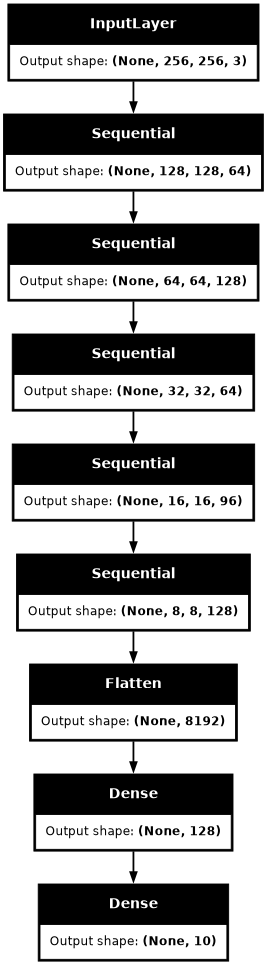

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [41]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
)

Epoch 1/20


W0000 00:00:1716293357.043668     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716293357.044459     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 378ms/step - accuracy: 0.4663 - loss: 1.6781 - val_accuracy: 0.3815 - val_loss: 4.0642
Epoch 2/20


W0000 00:00:1716293449.859264     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 77s 271ms/step - accuracy: 0.6971 - loss: 0.9342 - val_accuracy: 0.5833 - val_loss: 1.3970
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - accuracy: 0.7642 - loss: 0.7209 - val_accuracy: 0.5625 - val_loss: 2.1759
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.8047 - loss: 0.5888 - val_accuracy: 0.6953 - val_loss: 1.1476
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.8503 - loss: 0.4634 - val_accuracy: 0.7044 - val_loss: 1.0661
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.8713 - loss: 0.3879 - val_accuracy: 0.6824 - val_loss: 1.2523
Epoch 7/20


W0000 00:00:1716293646.922055     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.8907 - loss: 0.3362 - val_accuracy: 0.6836 - val_loss: 1.2802
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.8981 - loss: 0.3022 - val_accuracy: 0.7044 - val_loss: 1.5202
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.9163 - loss: 0.2539 - val_accuracy: 0.7188 - val_loss: 1.1621
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.9257 - loss: 0.2281 - val_accuracy: 0.7526 - val_loss: 1.0821
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.9397 - loss: 0.1788 - val_accuracy: 0.7435 - val_loss: 1.2636
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.9455 - loss: 0.1629 - val_accuracy: 0.7765 - val_loss: 1.2549
Epoch 13/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.9531 - loss: 0.1333 - val_accuracy: 0.7396 - val_loss: 1.3997
Epoch 14/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.9527 - loss: 0.1421 

In [44]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenette.keras")
model.save("foolsunet_imagenette_.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
new_model = tf.keras.models.load_model("foolsunet_imagenette.keras")

# Show the model architecture
new_model.summary()